In [2]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import pickle as pkl
import torch
import numpy as np
import matplotlib.pyplot as plt

from train import conf as conf_train
from vine import CVine

CPU times: user 20.5 s, sys: 60.6 ms, total: 20.5 s
Wall time: 35 s


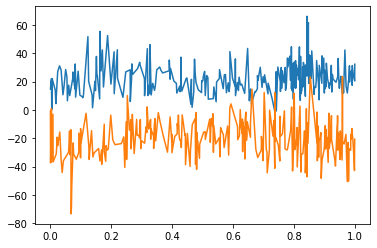

In [20]:
A = 0
D = 1
test_day = 5
N_points = 300
device='cuda:0' # can be cuda, but no need for this here

with open(f'/home/nina/CopulaGP/out/AA{A}D{D}_gV_trained.pkl',"rb") as f:
    trained = pkl.load(f)
with open(f"/home/nina/CopulaGP/datasets/AA{A}D{test_day}_gV_inD{D}_layer0.pkl",'rb') as f:
    test_data = pkl.load(f)
assert np.all(test_data['order'] == trained['order'])

train_X = torch.tensor(trained['X'], device=device).float()

test_X = torch.tensor(test_data['X'], device=device).float()

train_idxs = torch.randperm(train_X.numel())[:N_points]
test_idxs  = torch.randperm(test_X.numel())[:N_points]

inputs  = torch.cat((train_X[train_idxs],test_X[test_idxs]),0)

train_Y = torch.tensor(trained['Y'], device=device).float()
test_Y = torch.tensor(test_data['Y'], device=device).float()

outputs = torch.cat((train_Y[train_idxs],test_Y[test_idxs]),0)
inputs_subset, sort_idxs = torch.sort(inputs,dim=0)

%time joint_vine = CVine.marginalize(trained['models'],inputs_subset)
log_prob = joint_vine.log_prob(outputs[sort_idxs])

train_ll = log_prob[sort_idxs<N_points]
test_ll = log_prob[sort_idxs>=N_points]
plt.plot(inputs_subset[sort_idxs<N_points].cpu().numpy(),train_ll.cpu().numpy())
plt.plot(inputs_subset[sort_idxs>=N_points].cpu().numpy(),test_ll.cpu().numpy())

In [23]:
model = trained['models'][0][1].bvcopulas


[['Independence', None], ['Gaussian', None], ['Clayton', '270°']]

In [3]:
import glob
files = glob.glob(f"{conf_train.path2outputs}/*trained.pkl")
files

['/home/nina/CopulaGP/out/AA0D1_gV_trained.pkl']

In [7]:

X = torch.linspace(0,1,N_points,device=device)
sem_tol = 0.05

# for file in files:
#     with open(file,"rb") as f:
#         trained = pkl.load(f)

#     print(len(trained['models']))
    
#     %time vine = CVine.marginalize(trained['models'],X)
#     vineC = CVine(vine.layers[1:],X,device=X.device)
    
#     %time H  =  vine.entropy(sem_tol=sem_tol,mc_size=3500,v=True).cpu().numpy()
#     %time HC = vineC.entropy(sem_tol=sem_tol,mc_size=3500,v=True).cpu().numpy()
    
#     d = {}
#     d['H'] = H
#     d['vine'] = vine
#     d['inputs'] = X
#     with open(f"{file[:-11]}vine.pkl","wb") as f:
#         pkl.dump(d,f)

''

In [8]:
file = '/home/nina/CopulaGP/out/AA0D1_gV_trained.pkl'
with open(file,"rb") as f:
    trained = pkl.load(f)

In [9]:
# X = torch.tensor(trained['X'], device=device).float()
# idxs = torch.randperm(X.numel())[:N_points]
# inputs_subset,_ = torch.sort(X[idxs],dim=0)
len(trained['models'])

20

In [10]:
%time vine = CVine.marginalize(trained['models'],X)
vineC = CVine(vine.layers[1:],X,device=X.device)

CPU times: user 21.7 s, sys: 43.9 ms, total: 21.7 s
Wall time: 36.6 s


In [ ]:
%time H  =  vine.entropy(sem_tol=sem_tol,mc_size=3500,v=True).cpu().numpy()
%time HC = vineC.entropy(sem_tol=sem_tol,mc_size=3500,v=True).cpu().numpy()

tensor(3.4067, device='cuda:0')
tensor(2.4022, device='cuda:0')
tensor(1.9491, device='cuda:0')
tensor(1.6810, device='cuda:0')


In [ ]:
plt.scatter(X.cpu().numpy(),H)
plt.scatter(X.cpu().numpy(),HC)

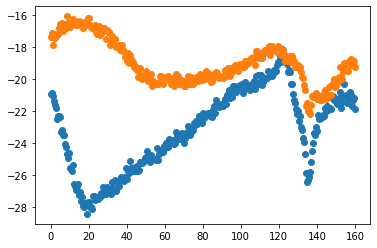

In [26]:
plt.scatter(X.cpu().numpy()*160,H)
plt.scatter(X.cpu().numpy()*160,HC)

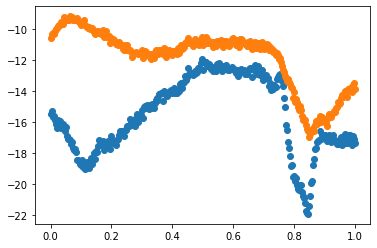

In [18]:
plt.scatter(X.cpu().numpy(),H)
plt.scatter(X.cpu().numpy(),HC)

In [ ]:
d = {}
d['H'] = H
d['vine'] = vine
d['inputs'] = X
with open(f"{file[:-11]}vine.pkl","wb") as f:
    pkl.dump(d,f)

In [ ]:
sem_tol = 0.1

In [16]:
trained['models'][0][2].bvcopulas

[['Independence', None],
 ['Gaussian', None],
 ['Clayton', '90°'],
 ['Clayton', '270°']]

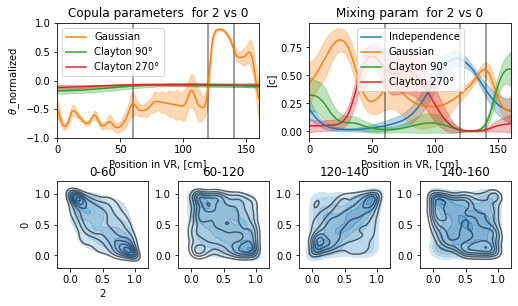

In [18]:
model = trained['models'][0][2]
X = torch.tensor(trained['X'], device=device).float()
Y = torch.tensor(trained['Y'][...,[1,0]], device=device).float()

from utils import Plot_Fit

Plot_Fit(model.model_init(device), trained['X'], trained['Y'][...,[1,0]], 
         '2', '0', device, order=None, interval_ends=np.array([0,60,120,140,160]));


In [19]:
mix = model.model_init(device).marginalize(X)

In [17]:
# mix.mix[0] = 0.
# mix.mix[1] = 0.
# mix.mix[2] = 1.
# mix.mix

# clcl = mix.log_prob(Y)
# clcl

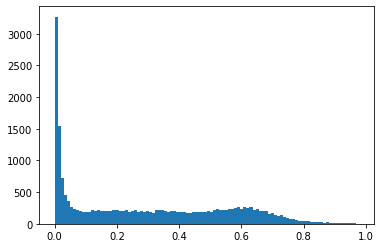

In [20]:
pCgY = mix.tail(Y)
cl = pCgY.cpu().numpy()
# cl = np.clip(cl,0,1)
plt.hist(cl,bins=100);

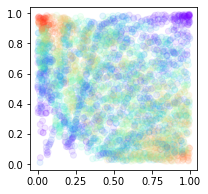

In [21]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 5
mask = (trained['X']>140/160) & (trained['X']<180/160)# & (cl>1.)
# cl = (cl-1)/(cl.max()-1)
plt.scatter(*trained['Y'][mask][:,[1,0]].T,color=cm.rainbow(cl[mask]),alpha=0.1)

In [6]:
# with open(f"{conf_train.path2data}/A0D1_gV_layer0.pkl","rb") as f:
#     data = pkl.load(f)
# order = data['order']

# with open(f"{conf_train.path2data}/AA0D1_gV_layer0.pkl","rb") as f:
#     dataA = pkl.load(f)
# orderA = dataA['order']
# invA = np.argsort(orderA)
# reorder = invA[order]

# ll = vine.log_prob(test_y)
# ll.mean()